Tema 1 - AI2


Nume: Văideanu Renata - Georgia

Grupa: 342 C4



Importul bibliotecilor necesare

In [2]:
import os
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color
from sklearn.decomposition import PCA
from skimage import exposure
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import glob
import cv2





# cerinta 3
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif

In [3]:
# Schimbă calea către directoarele locale
path2 = r"F:\Facultate\Anul 4\Semestrul 1\IA2\Teme\Tema1\fruits-360"
fruits = os.listdir(os.path.join(path2, "Training"))
dim = 100

def readFruitsInput(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    path = os.path.join(path2, data_type)
    for i, f in enumerate(fruits):
        p = os.path.join(path, f)
        j = 0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
            images.append(image)
            labels.append(i)
            j += 1
        if print_n:
            print(f"There are {j} {data_type.upper()} images of {fruits[i].upper()}")
    # Conversie la array-uri NumPy
    images = np.array(images, dtype='float32')
    labels = np.array(labels)
    return images, labels


# Citirea datelor în format aplatizat
x_train_fruits, y_train_fruits = readFruitsInput(fruits, 'Training', print_n=True)
x_test_fruits, y_test_fruits = readFruitsInput(fruits, 'Test', print_n=True)

# Verificarea formelor datelor
print("Fruit Training data shape:", x_train_fruits.shape, y_train_fruits.shape)
print("Fruit Test data shape:", x_test_fruits.shape, y_test_fruits.shape)


There are 473 TRAINING images of APPLE 6
There are 492 TRAINING images of APPLE BRAEBURN 1
There are 444 TRAINING images of APPLE CRIMSON SNOW 1
There are 480 TRAINING images of APPLE GOLDEN 1
There are 492 TRAINING images of APPLE GOLDEN 2
There are 481 TRAINING images of APPLE GOLDEN 3
There are 492 TRAINING images of APPLE GRANNY SMITH 1
There are 702 TRAINING images of APPLE HIT 1
There are 456 TRAINING images of APPLE PINK LADY 1
There are 492 TRAINING images of APPLE RED 1
There are 492 TRAINING images of APPLE RED 2
There are 429 TRAINING images of APPLE RED 3
There are 490 TRAINING images of APPLE RED DELICIOUS 1
There are 492 TRAINING images of APPLE RED YELLOW 1
There are 672 TRAINING images of APPLE RED YELLOW 2
There are 492 TRAINING images of APRICOT 1
There are 427 TRAINING images of AVOCADO 1
There are 491 TRAINING images of AVOCADO RIPE 1
There are 490 TRAINING images of BANANA 1
There are 450 TRAINING images of BANANA LADY FINGER 1
There are 490 TRAINING images of BANA

In [4]:
# Încărcarea datasetului Fashion-MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Normalizarea datelor Fashion-MNIST
x_train_fashion, x_test_fashion = x_train_fashion / 255.0, x_test_fashion / 255.0


# Cerinta 1 Extragerea de atribute (Feature Extraction)

### 1. Extragerea de atribute folosind PCA (Principal Component Analysis)

In [6]:
no_components = 20
pca = PCA(no_components)


FASHION

In [7]:
x_train_fashion_flat = x_train_fashion.reshape(x_train_fashion.shape[0], -1)
x_test_fashion_flat = x_test_fashion.reshape(x_test_fashion.shape[0], -1)

x_train_pca_fashion = pca.fit_transform(x_train_fashion_flat)
x_test_pca_fashion = pca.transform(x_test_fashion_flat)

x_train_reconstructed_fashion = pca.inverse_transform(x_train_pca_fashion)

print(f"Numărul de componente principale selectate: {pca.n_components_}")

print(np.cumsum(pca.explained_variance_ratio_[:20]))


Numărul de componente principale selectate: 20
[0.29039228 0.46794538 0.5281376  0.57771188 0.61618843 0.65079612
 0.67421303 0.69326717 0.7067656  0.71990827 0.72983702 0.73896957
 0.74662749 0.75322449 0.75930272 0.76520069 0.77071999 0.77596392
 0.78054408 0.78508769]


FRUITS

In [21]:
# Aplatizăm datele pentru a putea aplica PCA
x_train_fruits_flat = x_train_fruits.reshape(x_train_fruits.shape[0], -1)
x_test_fruits_flat = x_test_fruits.reshape(x_test_fruits.shape[0], -1)

# Aplicăm PCA pe datele de antrenament
x_train_pca_fruits = pca.fit_transform(x_train_fruits_flat)
x_test_pca_fruits = pca.fit_transform(x_test_fruits_flat)

# Reconstruim imaginile folosind PCA
x_train_reconstructed = pca.inverse_transform(x_train_pca_fruits)

# Afișăm informații despre PCA
print(f"Numărul de componente principale selectate pentru Fruits-360: {x_train_pca_fruits.shape[1]}")

print(np.cumsum(pca.explained_variance_ratio_[:20]))

Numărul de componente principale selectate pentru Fruits-360: 20
[0.30149943 0.42006278 0.52981776 0.5750936  0.61873525 0.649147
 0.67432094 0.6934641  0.7089935  0.724376   0.73847926 0.750266
 0.75981545 0.7687505  0.7757854  0.78231984 0.7882892  0.79399973
 0.7993713  0.8044887 ]


### 2. Extragerea de atribute folosind HOG (Histogram of Oriented Gradients)

FASHION

In [9]:
# Funcția pentru extragerea caracteristicilor HOG
def extract_hog_features_fashion(images):
    hog_features = []
    for img in images:
        features = hog(img, 
                    pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys', 
                    visualize=False)
        hog_features.append(features)

    return np.array(hog_features)

In [10]:
x_train_hog_fashion = extract_hog_features_fashion(x_train_fashion)
x_test_hog_fashion = extract_hog_features_fashion(x_test_fashion)

# Afișarea dimensiunii vectorilor HOG pentru imaginile de antrenament
print(f"Dimensiunea vectorilor HOG pentru imaginile de antrenament: {x_train_hog_fashion.shape[1]}")


Dimensiunea vectorilor HOG pentru imaginile de antrenament: 144


FRUITS

In [ ]:
# Definirea funcției pentru extragerea caracteristicilor HOG
def extract_hog_features_fruits(images):
    hog_features = []
    for image in images:
        # Reconstruim imaginea dacă este aplatizată
        # Convertim imaginea la grayscale
        gray_image = color.rgb2gray(image)
        
        # Aplicăm HOG pentru extragerea caracteristicilor
        hog_feature = hog(
            gray_image, 
            pixels_per_cell=(16, 16),  # Poți ajusta acest parametru
            cells_per_block=(2, 2),   # La fel și acest parametru
            block_norm='L2-Hys', 
            visualize=False
        )
        hog_features.append(hog_feature)
    
    # Returnăm caracteristicile HOG ca array NumPy
    return np.array(hog_features)


In [ ]:
# Extragem caracteristicile HOG pentru seturile de antrenament și test
x_train_hog_fruits = extract_hog_features_fruits(x_train_fruits)
x_test_hog_fruits = extract_hog_features_fruits(x_test_fruits)

x_train_hog_fruits_flat = x_train_hog_fruits.reshape(x_train_hog_fruits.shape[0], -1)
x_test_hog_fruits_flat = x_test_hog_fruits.reshape(x_test_hog_fruits.shape[0], -1)

# Afișăm dimensiunea vectorilor HOG pentru setul de antrenament
print(f"Dimensiunea vectorilor HOG pentru imaginile de antrenament: {x_train_hog_fruits.shape[1]}")


Dimensiunea vectorilor HOG pentru imaginile de antrenament: 900


# Cerinta 2. Vizualizarea atributelor extrase

### 1. Analiza echilibrului de clase

FASHION

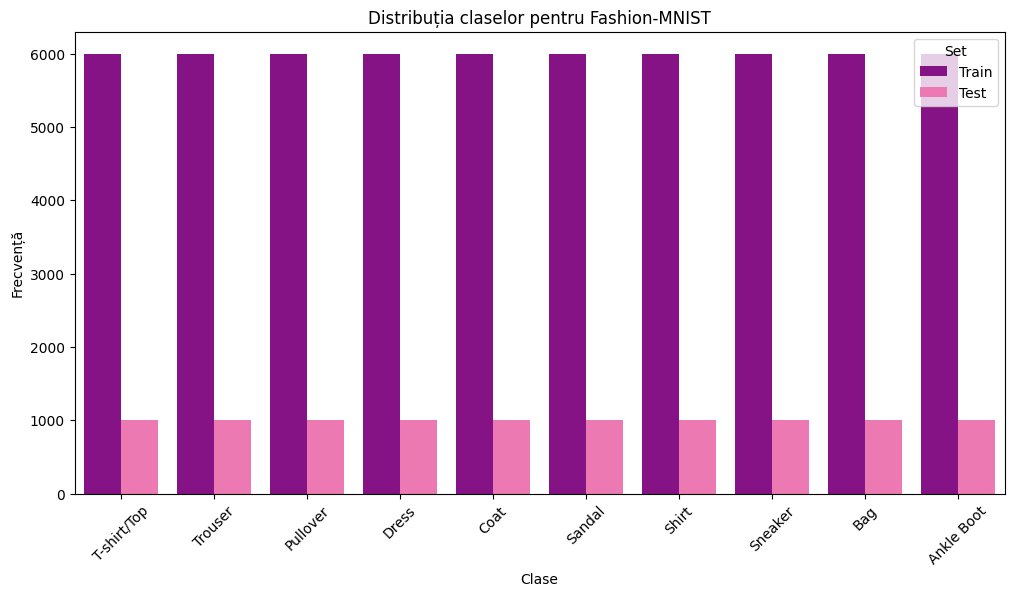

In [13]:
# Dicționar pentru denumirile claselor Fashion-MNIST
fashion_labels_map = {
    0: "T-shirt/Top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}

# --- Fashion-MNIST ---
# Creăm un DataFrame pentru etichetele setului de antrenament și test
df_train_labels_fashion = pd.DataFrame({'Label': y_train_fashion.flatten(), 'Set': 'Train'})  # Flatten pentru a evita erorile
df_test_labels_fashion = pd.DataFrame({'Label': y_test_fashion.flatten(), 'Set': 'Test'})  # Flatten pentru a evita erorile

# Combinăm cele două DataFrame-uri pentru Fashion-MNIST
df_fashion_combined = pd.concat([df_train_labels_fashion, df_test_labels_fashion])

# Afișăm distribuția combinată a claselor pentru Fashion-MNIST
plt.figure(figsize=(12, 6))
sns.countplot(x='Label', hue='Set', data=df_fashion_combined, palette=['#990099', '#FF66B2'])
plt.title('Distribuția claselor pentru Fashion-MNIST')
plt.xlabel('Clase')
plt.ylabel('Frecvență')

# Rotim etichetele de pe axa X pentru a le face mai lizibile
plt.xticks(ticks=range(len(fashion_labels_map)), labels=[fashion_labels_map[i] for i in sorted(df_fashion_combined['Label'].unique())], rotation=45)
plt.show()

FRUITS

In [31]:
path = os.path.join(path2, "Training")
fruits_class_names = sorted(os.listdir(path))
print(fruits_class_names)

['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana Lady Finger 1', 'Banana Red 1', 'Beetroot 1', 'Blueberry 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Chestnut 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Corn Husk 1', 'Cucumber 1', 'Cucumber 3', 'Cucumber Ripe 1', 'Cucumber Ripe 2', 'Dates 1', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Ginger Root 1', 'Granadilla 1', 'Grape Blue 1', 'Grape Pink 1', 'Grape White 1', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink 1', 'Grapefruit White 1', 'Guava 1

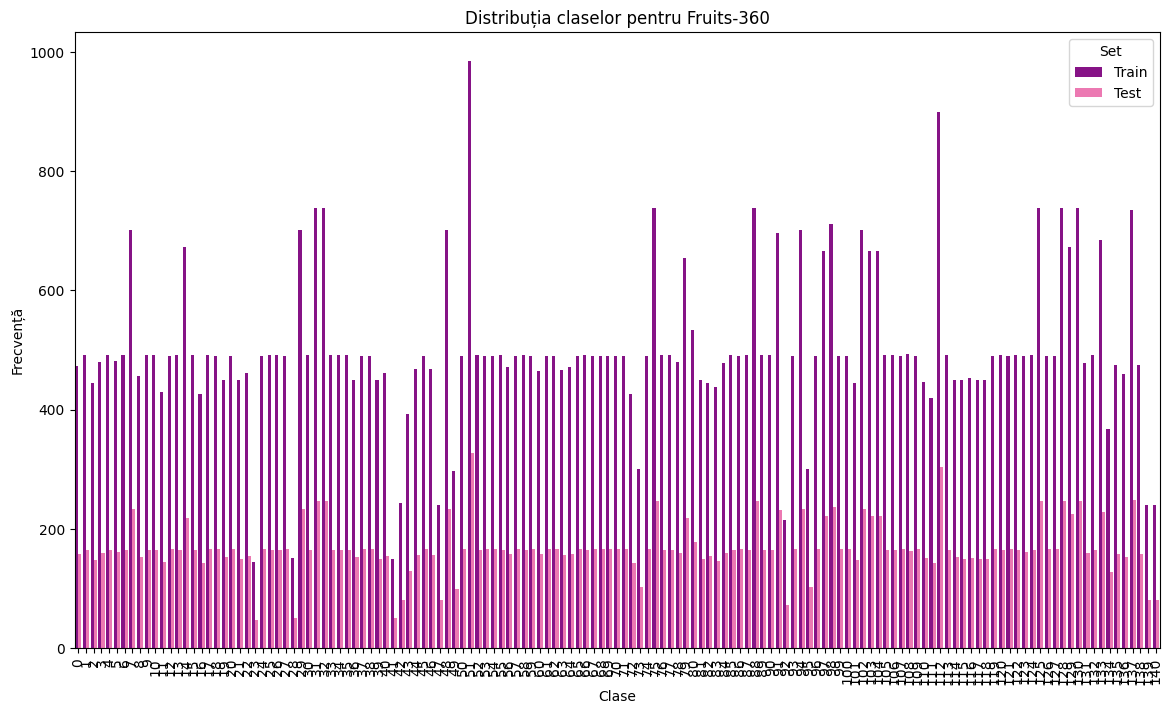

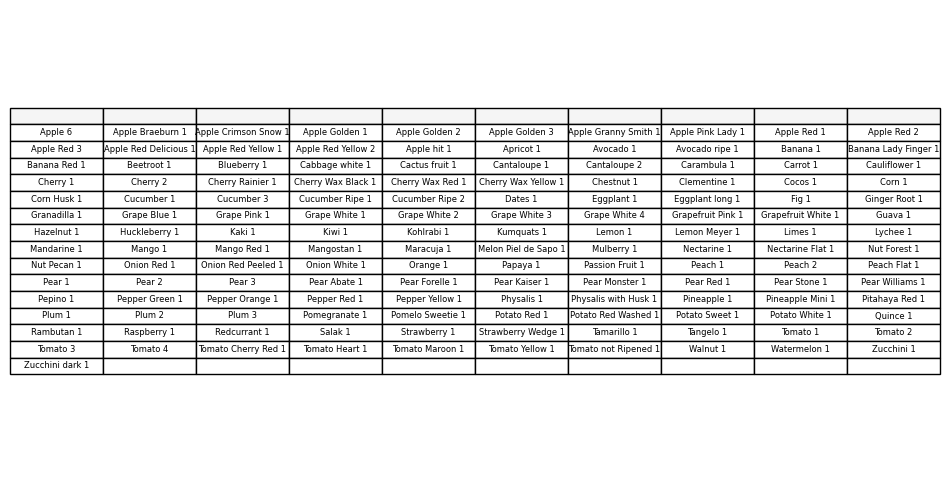

In [15]:
# Creăm DataFrame-uri pentru etichetele seturilor de antrenament și test
df_train_labels_fruits = pd.DataFrame({'Label': y_train_fruits, 'Set': 'Train'})
df_test_labels_fruits = pd.DataFrame({'Label': y_test_fruits, 'Set': 'Test'})

# Combinăm cele două DataFrame-uri pentru Fruits-360
df_fruits_combined = pd.concat([df_train_labels_fruits, df_test_labels_fruits])


# --- Plot pentru distribuția claselor cu indicii ---
plt.figure(figsize=(14, 8))
sns.countplot(x='Label', hue='Set', data=df_fruits_combined, palette=['#990099', '#FF66B2'])

# Setăm indicii pe axa X
plt.xticks(ticks=range(len(fruits_class_names)), labels=range(len(fruits_class_names)), rotation=90)

plt.title('Distribuția claselor pentru Fruits-360')
plt.xlabel('Clase')
plt.ylabel('Frecvență')
plt.show()


# --- Creăm un tabel cu denumirile claselor corespunzătoare fiecărui indice ---
num_columns = 10

# Creăm un tabel direct în pandas din lista de denumiri
fruits_class_mapping = pd.DataFrame(
    [fruits_class_names[i:i + num_columns] for i in range(0, len(fruits_class_names), num_columns)]
)

# Creăm imaginea tabelului
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')  # Ascundem axele
table = ax.table(cellText=fruits_class_mapping.values, loc='center', cellLoc='center', colColours=["#f5f5f5"]*fruits_class_mapping.shape[1])
table.auto_set_font_size(False)  # Dezactivăm dimensiunea automată a fontului
table.set_fontsize(6)  # Setăm un font mai mare pentru o citire mai clară


# Afișăm imaginea
plt.show()

### 2.1. Vizualizări cantitative ale atributelor extrase
PCA:

FASHION

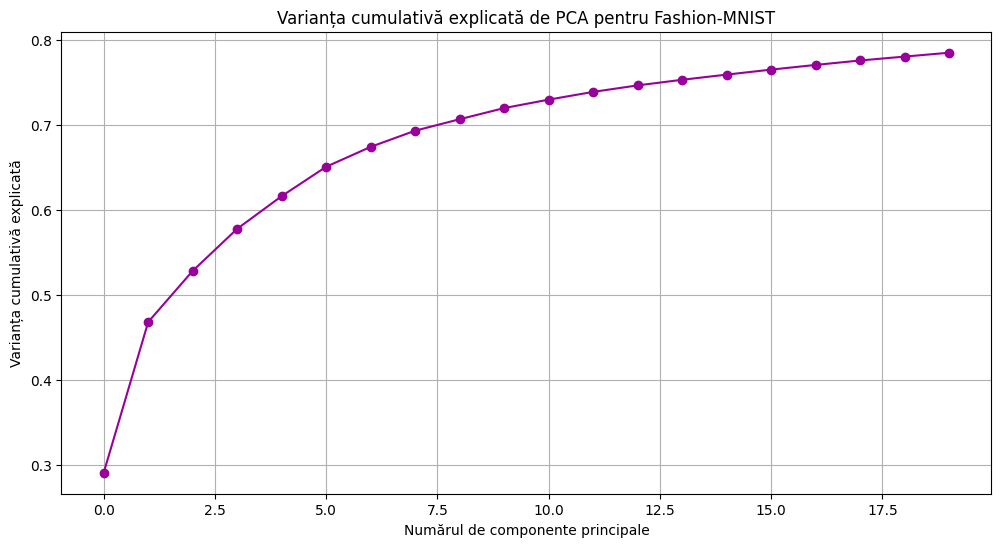

Tabel cu varianța explicată cumulativă:
   Număr de componente  Varianță explicată cumulativă (%)
0                    5                          61.618843
1                   10                          71.990827
2                   15                          75.930301
3                   20                          78.509556


In [19]:
# --- Fashion-MNIST --- #
x_train_pca_fashion = pca.fit_transform(x_train_fashion_flat)

# Vizualizarea varianței explicate de PCA
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='#990099')
plt.title('Varianța cumulativă explicată de PCA pentru Fashion-MNIST')
plt.xlabel('Numărul de componente principale')
plt.ylabel('Varianța cumulativă explicată')
plt.grid(True)
plt.show()

# Crearea unui tabel cu varianța explicată cumulativă
num_components = [5, 10, 15, 20]  # Exemple de numere de componente
explained_variance_table = pd.DataFrame({
    'Număr de componente': num_components,
    'Varianță explicată cumulativă (%)': [np.sum(pca.explained_variance_ratio_[:n]) * 100 for n in num_components]
})

# Afișarea tabelului
print("Tabel cu varianța explicată cumulativă:")
print(explained_variance_table)


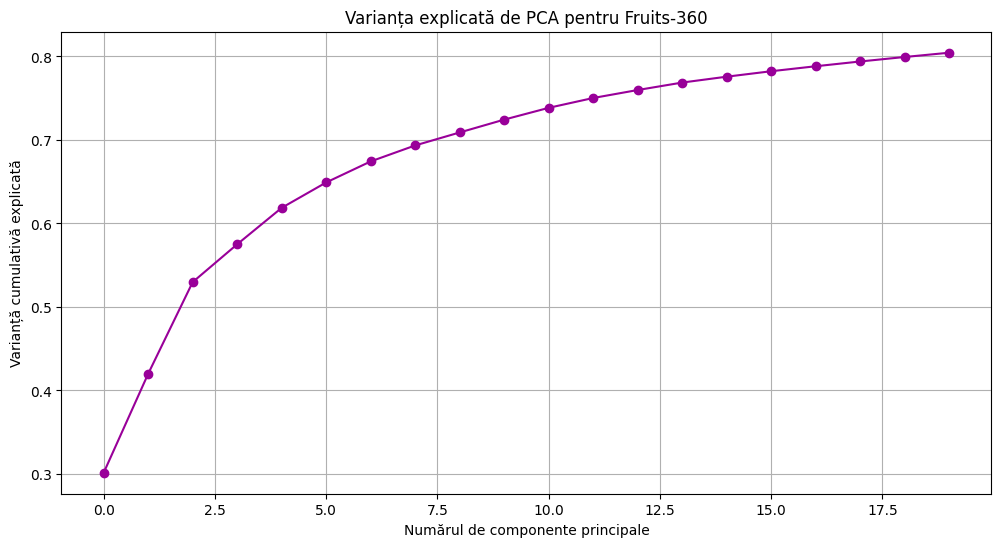

Tabel cu varianța explicată cumulativă:
   Număr de componente  Varianță explicată cumulativă (%)
0                    5                          61.873525
1                   10                          72.437608
2                   15                          77.578545
3                   20                          80.448878


In [22]:
# --- Fruits-360 --- #
x_train_pca_fruits = pca.transform(x_train_fruits_flat)

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='#990099')
plt.xlabel('Numărul de componente principale')
plt.ylabel('Varianță cumulativă explicată')
plt.title('Varianța explicată de PCA pentru Fruits-360')
plt.grid(True)
plt.show()

# Crearea unui tabel cu varianța explicată cumulativă
num_components = [5, 10, 15, 20]  # Exemple de numere de componente
explained_variance_table = pd.DataFrame({
    'Număr de componente': num_components,
    'Varianță explicată cumulativă (%)': [np.sum(pca.explained_variance_ratio_[:n]) * 100 for n in num_components]
})

# Afișarea tabelului
print("Tabel cu varianța explicată cumulativă:")
print(explained_variance_table)


HOG:

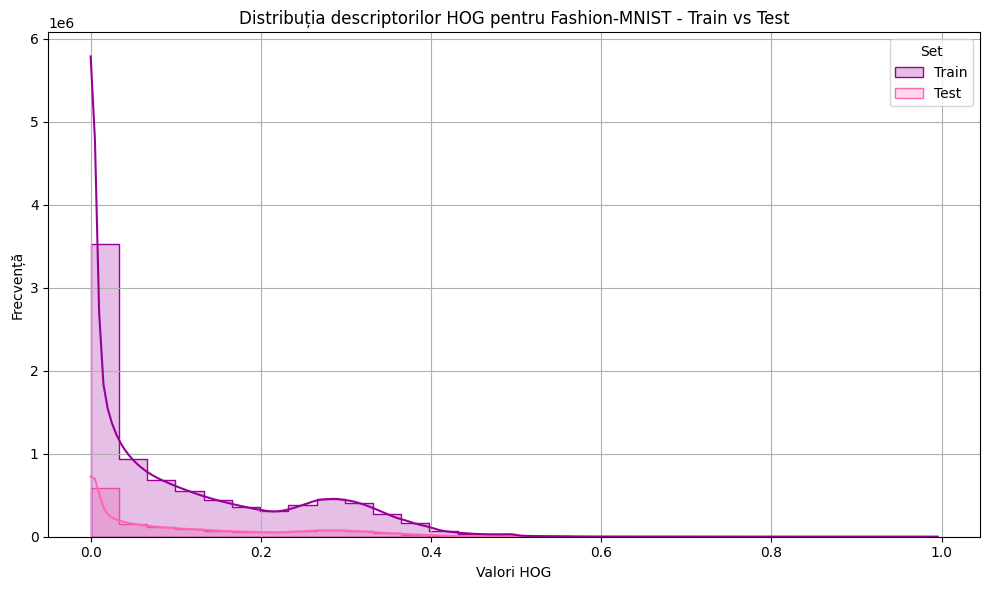

Statistici descriptive pentru valorile HOG:
           count      mean       std  min       25%       50%       75%  \
Set                                                                       
Test   1440000.0  0.112106  0.123329  0.0  0.005586  0.061235  0.198050   
Train  8640000.0  0.111845  0.123565  0.0  0.005360  0.060399  0.197438   

            max  
Set              
Test   0.888555  
Train  0.995428  


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Creăm un DataFrame pentru a include seturile de date
df_fashion_hog = pd.DataFrame({
    'HOG Value': np.concatenate([x_train_hog_fashion.flatten(), x_test_hog_fashion.flatten()]),
    'Set': ['Train'] * len(x_train_hog_fashion.flatten()) + ['Test'] * len(x_test_hog_fashion.flatten())
})

# Vizualizare distribuția valorilor descriptorilor HOG pentru Fashion-MNIST (Train vs Test)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_fashion_hog, x='HOG Value', hue='Set', kde=True, bins=30, palette=['#990099', '#FF66B2'], element='step')
plt.title('Distribuția descriptorilor HOG pentru Fashion-MNIST - Train vs Test')
plt.xlabel('Valori HOG')
plt.ylabel('Frecvență')
plt.grid(True)
plt.tight_layout()
plt.show()


# Statistici descriptive pentru întreg setul de date
statistics = df_fashion_hog.groupby('Set')['HOG Value'].describe()

# Afișează tabelul cu statistici
print("Statistici descriptive pentru valorile HOG:")
print(statistics)

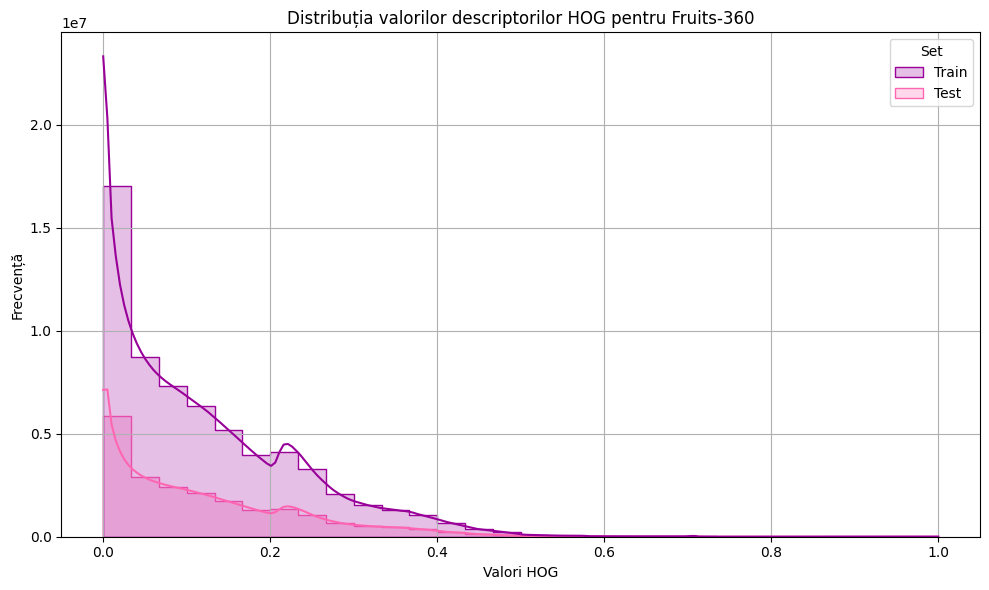

Statistici descriptive pentru valorile HOG:
            count      mean       std  min       25%       50%       75%  max
Set                                                                          
Test   21257100.0  0.122328  0.113159  0.0  0.028224  0.092112  0.189897  1.0
Train  63441900.0  0.122982  0.112421  0.0  0.029592  0.093521  0.190837  1.0


In [ ]:
hog_values = np.concatenate([x_train_hog_fruits_flat.flatten(), x_test_hog_fruits_flat.flatten()])

df_fruits_hog = pd.DataFrame({
    'HOG Value': hog_values,
    'Set': ['Train'] * x_train_hog_fruits_flat.size + ['Test'] * x_test_hog_fruits_flat.size
})

# Vizualizarea distribuției valorilor descriptorilor HOG pentru Fruits-360
plt.figure(figsize=(10, 6))
sns.histplot(data=df_fruits_hog, x='HOG Value', hue='Set', kde=True, bins=30, palette=['#990099', '#FF66B2'], element='step')
plt.title('Distribuția valorilor descriptorilor HOG pentru Fruits-360')
plt.xlabel('Valori HOG')
plt.ylabel('Frecvență')
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistici descriptive pentru întreg setul de date
statistics = df_fruits_hog.groupby('Set')['HOG Value'].describe()

# Afișează tabelul cu statistici
print("Statistici descriptive pentru valorile HOG:")
print(statistics)


### 2.2. Vizualizări calitative ale atributelor extrase

#### HOG Fashion

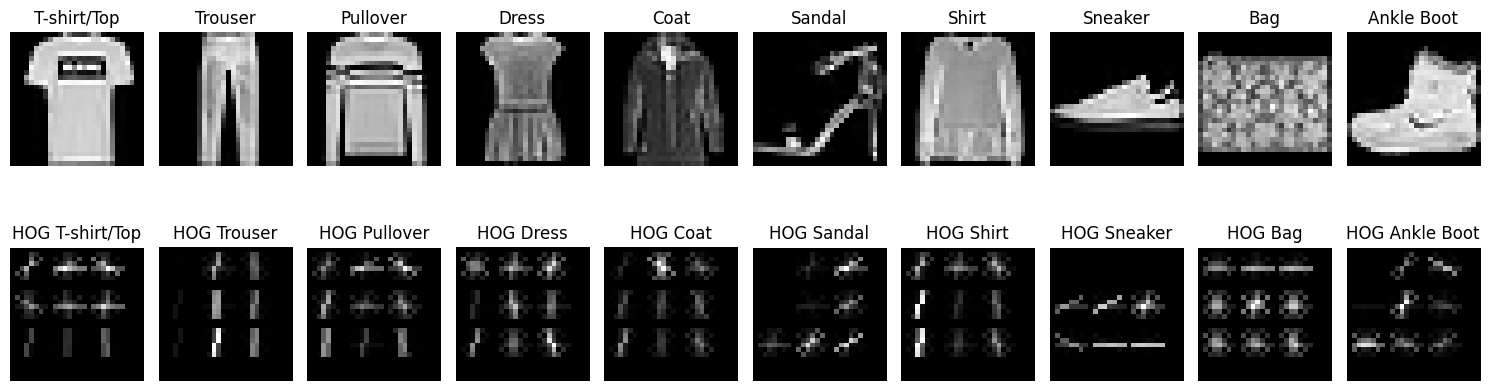

In [23]:
# Reconstrucția imaginilor Fashion-MNIST cu PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Alegem câte o imagine din fiecare clasă
unique_classes = np.unique(y_train_fashion)
images_per_class = [x_train_fashion[np.where(y_train_fashion == cls)[0][0]] for cls in unique_classes]
indices_per_class = [np.where(y_train_fashion == cls)[0][0] for cls in unique_classes]

# Afișăm imaginile originale și descriptorii HOG
fig, axes = plt.subplots(2, len(unique_classes), figsize=(15, 5))
for i, image in enumerate(images_per_class):
    # Calculăm descriptorii HOG
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                  block_norm='L2-Hys', visualize=True)

    # Originală
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].set_title(fashion_labels_map[i])
    axes[0, i].axis('off')

    # HOG
    axes[1, i].imshow(hog_image, cmap='gray')
    axes[1, i].set_title(f"HOG {fashion_labels_map[i]}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

#### PCA Fashion

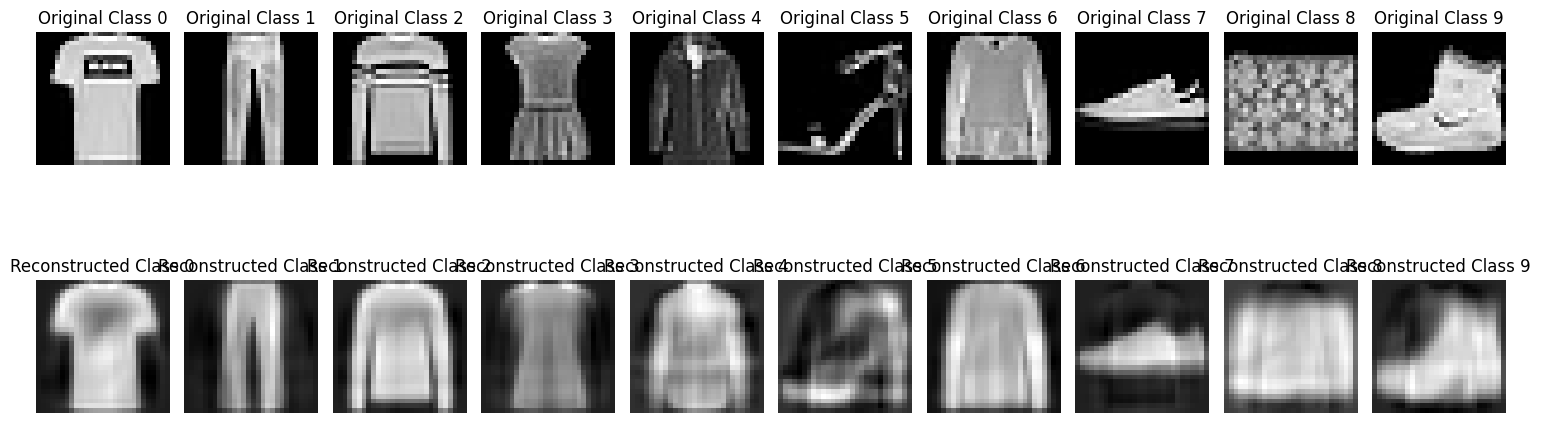

In [28]:
x_train_pca_fashion = pca.transform(x_train_fashion_flat)

x_train_reconstructed_fashion = pca.inverse_transform(x_train_pca_fashion)
reconstructed_images_per_class = x_train_reconstructed_fashion[indices_per_class]

# Plot the original and reconstructed images using PCA
fig, axes = plt.subplots(2, len(unique_classes), figsize=(15, 6))

for i, image in enumerate(images_per_class):
    # Original image
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].set_title(f'Original Class {unique_classes[i]}')
    axes[0, i].axis('off')

    # Reconstructed image
    reconstructed_image = reconstructed_images_per_class[i].reshape(x_train_fashion.shape[1:])  # Reshape to original dimensions
    axes[1, i].imshow(reconstructed_image, cmap='gray')
    axes[1, i].set_title(f'Reconstructed Class {unique_classes[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


#### HOG FRUITS

In [32]:
import os
import glob
import pandas as pd

# Crearea unui dicționar cu numele claselor și numărul de imagini pentru fiecare clasă
class_counts = {class_name: len(glob.glob(os.path.join(path, class_name, "*.jpg"))) for class_name in fruits_class_names}

# Crearea unui DataFrame din dicționarul anterior și sortarea acestuia în ordine descrescătoare
class_counts_df = pd.Series(class_counts).sort_values(ascending=False)

# Extragem primele 10 clase cele mai populate
top_10_classes = class_counts_df.head(10)

# Afișăm top 10 clase
print(top_10_classes)


Grape Blue 1            984
Plum 3                  900
Melon Piel de Sapo 1    738
Tomato 3                738
Cherry Rainier 1        738
Cherry 2                738
Tomato 1                738
Strawberry Wedge 1      738
Peach 2                 738
Walnut 1                735
dtype: int64


In [34]:
# Extragem câte o imagine din fiecare dintre cele mai numeroase 10 clase
images_per_class_fruits = []
top_10_class_names = top_10_classes.index.tolist()  # Numele claselor cele mai frecvente
for class_name in top_10_class_names:
    image_path = glob.glob(os.path.join(path, class_name, "*.jpg"))[0]  # Alege prima imagine din fiecare clasă
    image = plt.imread(image_path)
    images_per_class_fruits.append(image)


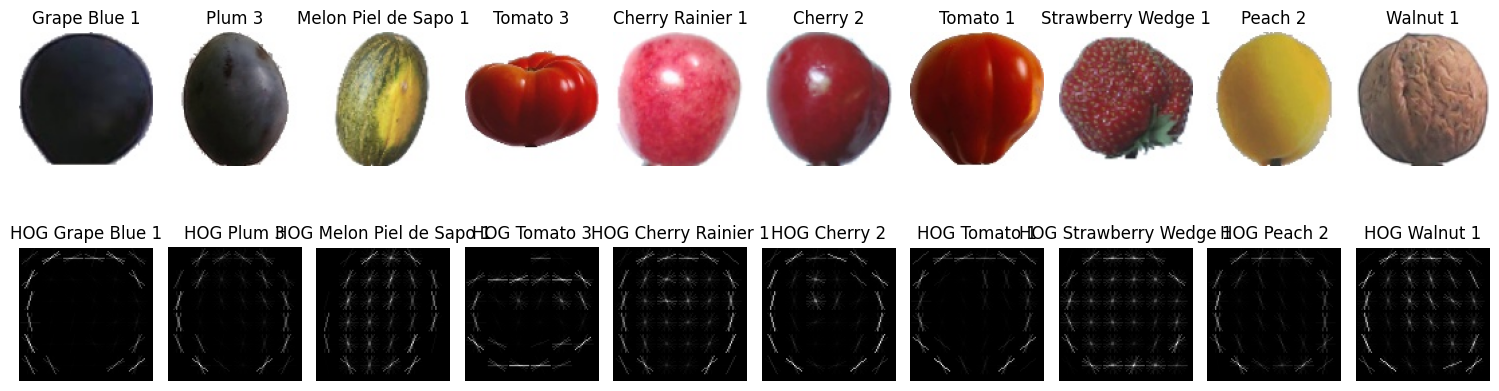

In [31]:
# Afișăm imaginile originale și descriptorii HOG
fig, axes = plt.subplots(2, len(images_per_class_fruits), figsize=(15, 5))

for i, image in enumerate(images_per_class_fruits):
    gray_image = color.rgb2gray(image)  # Convertim la grayscale
    hog_features, hog_image = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                                  block_norm='L2-Hys', visualize=True)
    
    # Originală
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"{top_10_class_names[i]}")
    axes[0, i].axis('off')

    # HOG
    axes[1, i].imshow(hog_image, cmap='gray')
    axes[1, i].set_title(f"HOG {top_10_class_names[i]}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

#### PCA FRUITS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

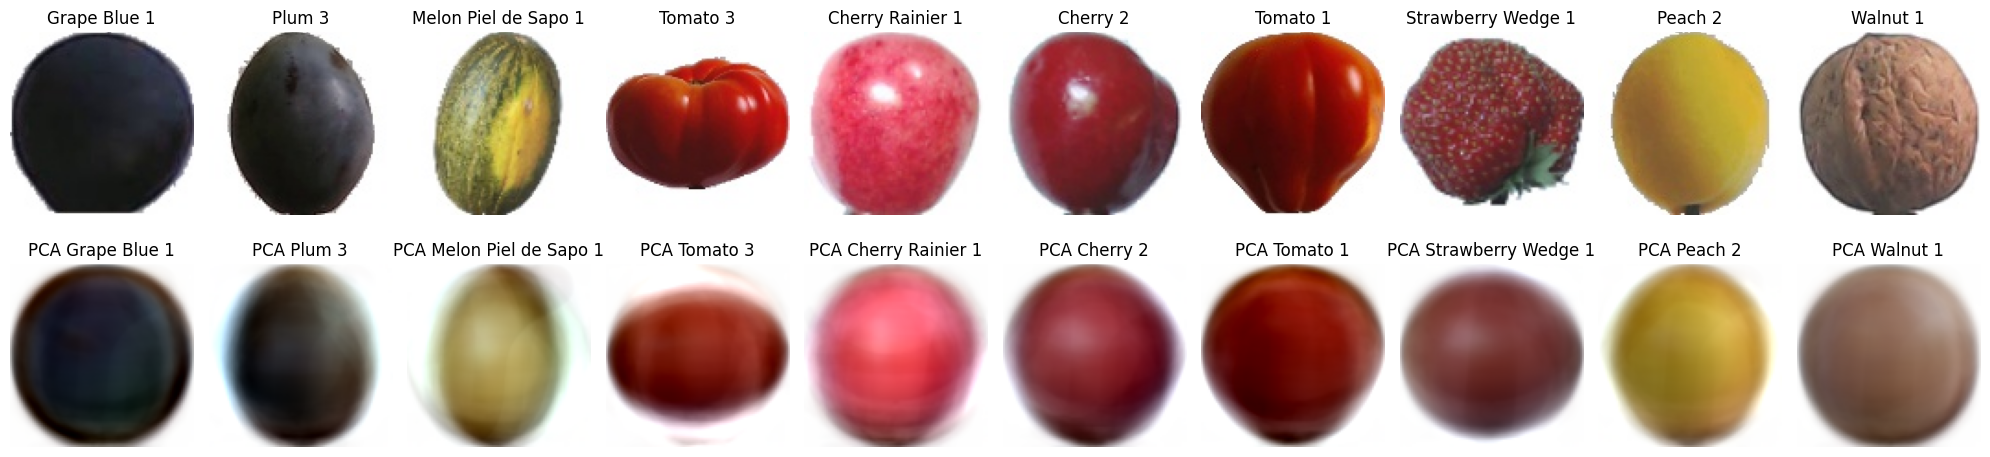

In [34]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Asigură-te că PCA este antrenat pe setul de date corespunzător
# Reține că x_train_fruits_flat ar trebui să fie deja un set de date complet (imaginile netezite)

# Antrenarea PCA
x_train_fruits_pca = pca.transform(x_train_fruits_flat)  # Transformă datele de antrenament

# Apoi pentru reconstrucția imaginilor folosind PCA
pca_reconstructed_images = []

# Folosim PCA pentru a reconstrui fiecare imagine
for i, image in enumerate(images_per_class_fruits):
    image_flat = image.reshape(-1)  # Flatten original image
    transformed_image_pca = pca.transform([image_flat])  # Aplicăm PCA pentru a reduce dimensiunea
    
    # Reconstruim imaginea din componentele principale
    reconstructed_image_flat = pca.inverse_transform(transformed_image_pca)  # Reconstruim imaginea
    reconstructed_image = reconstructed_image_flat.reshape(image.shape)  # Reshape to original dimensions
    pca_reconstructed_images.append(reconstructed_image)

# Vizualizare: Imagini originale și reconstruite cu PCA
fig, axes = plt.subplots(2, len(images_per_class_fruits), figsize=(20, 5))

for i, (original, pca_image) in enumerate(zip(images_per_class_fruits, pca_reconstructed_images)):
    # Originală
    axes[0, i].imshow(original)
    axes[0, i].set_title(f"{top_10_class_names[i]}")
    axes[0, i].axis('off')

    # PCA Reconstruită
    axes[1, i].imshow(pca_image/ 255.0)
    axes[1, i].set_title(f"PCA {top_10_class_names[i]}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


# Cerinta 3



In [25]:
# Importăm librăriile necesare
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
import matplotlib.pyplot as plt
from skimage.feature import hog

train_combined_features_fruits = np.hstack([x_train_pca_fruits, x_train_hog_fruits])
test_combined_features_fruits = np.hstack([x_test_pca_fruits, x_test_hog_fruits])

train_combined_features_fashion = np.hstack([x_train_pca_fashion, x_train_hog_fashion])
test_combined_features_fashion = np.hstack([x_test_pca_fashion, x_test_hog_fashion])



#### FRUITS

In [26]:
# Standardizare
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_combined_features_fruits)
x_test_scaled = scaler.transform(test_combined_features_fruits)

selector = VarianceThreshold(threshold=1)  # Ajustează pragul pentru selecție
x_train_selectedV = selector.fit_transform(x_train_scaled)
x_test_selectedV = selector.transform(x_test_scaled)

percentile_selector = SelectPercentile(score_func=f_classif, percentile=20)
x_train_selectedP = percentile_selector.fit_transform(x_train_selectedV, y_train_fruits)
x_test_selectedP = percentile_selector.transform(x_test_selectedV)

# Afișare dimensiuni
print(f"Original feature shape for training: {train_combined_features_fruits.shape}")
print(f"Selected feature shape for training: {x_train_selectedV.shape}")
print(f"Select Percentile shape for training: {x_train_selectedP.shape}")

print(f"Original feature shape for test: {test_combined_features_fruits.shape}")
print(f"Selected feature shape for test: {x_test_selectedV.shape}")
print(f"Select Percentile shape for test: {x_test_selectedP.shape}")


x_train_fruits_stand = x_train_selectedP
x_test_fruits_stand = x_test_selectedP


Original feature shape for training: (70491, 920)
Selected feature shape for training: (70491, 485)
Select Percentile shape for training: (70491, 97)
Original feature shape for test: (23619, 920)
Selected feature shape for test: (23619, 485)
Select Percentile shape for test: (23619, 97)


#### FASHION

In [27]:
# Standardizare
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_combined_features_fashion)
x_test_scaled = scaler.transform(test_combined_features_fashion)

selector = VarianceThreshold(threshold=1)  # Ajustează pragul pentru selecție
x_train_selectedV = selector.fit_transform(x_train_scaled)
x_test_selectedV = selector.transform(x_test_scaled)

percentile_selector = SelectPercentile(score_func=f_classif, percentile=30)
x_train_selectedP = percentile_selector.fit_transform(x_train_scaled, y_train_fashion)
x_test_selectedP = percentile_selector.transform(x_test_scaled)

# Afișare dimensiuni
print(f"Original feature shape for training: {train_combined_features_fashion.shape}")
print(f"Selected feature shape for training: {x_train_selectedV.shape}")
print(f"Select Percentile shape for training: {x_train_selectedP.shape}")

print(f"Original feature shape for test: {test_combined_features_fashion.shape}")
print(f"Selected feature shape for test: {x_test_selectedV.shape}")
print(f"Select Percentile shape for test: {x_test_selectedP.shape}")

x_train_fashion_stand = x_train_selectedP
x_test_fashion_stand = x_test_selectedP


Original feature shape for training: (60000, 164)
Selected feature shape for training: (60000, 85)
Select Percentile shape for training: (60000, 49)
Original feature shape for test: (10000, 164)
Selected feature shape for test: (10000, 85)
Select Percentile shape for test: (10000, 49)


# Cerinta 4

Biblioteci necesare

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

def printCM_fashion(func):
    # Predictions and evaluation
    y_pred_log_reg = func.predict(x_test_fashion_stand)
    print("Best Params:", func.best_params_)
    print("Logistic Regression Report:\n", classification_report(y_test_fashion, y_pred_log_reg))
    ConfusionMatrixDisplay.from_predictions(y_test_fashion, y_pred_log_reg, cmap='RdPu')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.show()  

#### FASHION

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'multi_class': 'multinomial', 'C': 1}
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76      1000
           1       0.95      0.94      0.95      1000
           2       0.62      0.64      0.63      1000
           3       0.79      0.82      0.80      1000
           4       0.63      0.66      0.65      1000
           5       0.91      0.89      0.90      1000
           6       0.48      0.39      0.43      1000
           7       0.86      0.90      0.88      1000
           8       0.93      0.93      0.93      1000
           9       0.93      0.92      0.92      1000

    accuracy                           0.79     10000
   macro avg       0.78      0.79      0.79     10000
weighted avg       0.78      0.79      0.79     10000



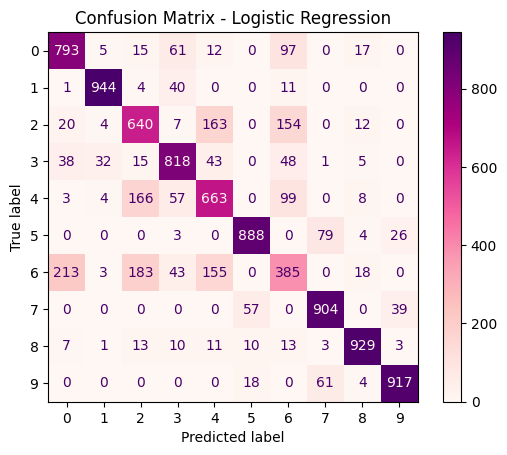

In [124]:

# Logistic Regression with Hyperparameter Tuning
log_reg = LogisticRegression(max_iter=1000)  # Sufficient iterations for convergence
param_grid_logreg = {
    'C': [0.01, 0.05, 0.1, 0.5, 1],
    'multi_class': ["ovr", "multinomial"]
}
log_reg_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_grid_logreg,
    cv=5,
    n_iter=10,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

log_reg_search.fit(x_train_fashion_stand, y_train_fashion)

printCM_fashion(log_reg_search)

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid

# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)

# Parametri specificați pentru Logistic Regression
param_grid_logreg = {
    'C': [0.01, 0.05, 0.1, 0.5, 1],
    'multi_class': ["ovr", "multinomial"]
}

# Generăm toate combinațiile posibile de parametri
param_combinations = list(ParameterGrid(param_grid_logreg))

# Parcurgem fiecare combinație de hiperparametri
for params in param_combinations:
    # Configurăm modelul cu parametrii curenți
    log_reg.set_params(**params)
    
    # Antrenăm modelul
    log_reg.fit(x_train_fashion_stand, y_train_fashion)
    
    # Facem predicții pe setul de test
    y_pred_fashion = log_reg.predict(x_test_fashion_stand)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- Logistic Regression Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(y_test_fashion, y_pred_fashion))



--- Logistic Regression Report for params: {'C': 0.01, 'multi_class': 'ovr'} ---
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1000
           1       0.92      0.93      0.92      1000
           2       0.57      0.65      0.61      1000
           3       0.73      0.78      0.75      1000
           4       0.61      0.65      0.63      1000
           5       0.90      0.84      0.87      1000
           6       0.47      0.30      0.37      1000
           7       0.83      0.89      0.86      1000
           8       0.90      0.90      0.90      1000
           9       0.92      0.91      0.92      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000


--- Logistic Regression Report for params: {'C': 0.01, 'multi_class': 'multinomial'} ---
              precision    recall  f1-score   support

           0  

C:\Users\Renata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'kernel': 'rbf', 'C': 10}
SVM Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.71      0.72      0.72      1000
           3       0.83      0.86      0.85      1000
           4       0.72      0.72      0.72      1000
           5       0.94      0.92      0.93      1000
           6       0.59      0.54      0.57      1000
           7       0.89      0.92      0.90      1000
           8       0.97      0.96      0.97      1000
           9       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



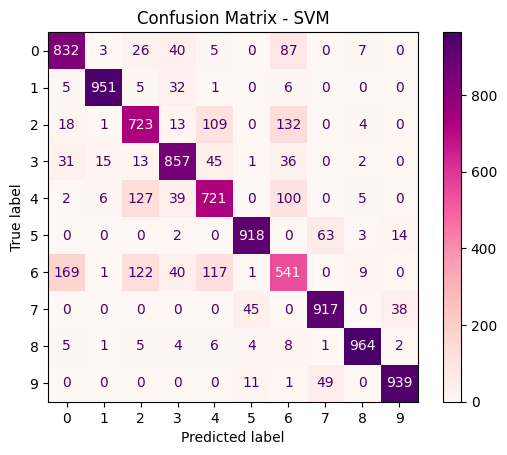

In [21]:
# 2. SVM - Fashion
svm = SVC(random_state=42)
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_search = RandomizedSearchCV(
    svm,
    param_distributions=param_grid_svm,
    cv=5,  # Reducem numărul de fold-uri
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1  # Paralelizăm pe toate nucleele disponibile
)
svm_search.fit(x_train_fashion_stand, y_train_fashion)

# Predictions and evaluation
y_pred_log_reg = svm_search.predict(x_test_fashion_stand)
print("Best Params:", svm_search.best_params_)
print("SVM Report:\n", classification_report(y_test_fashion, y_pred_log_reg))
ConfusionMatrixDisplay.from_predictions(y_test_fashion, y_pred_log_reg, cmap='RdPu')
plt.title('Confusion Matrix - SVM')
plt.show()  

In [126]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid

# SVM Model
svm = SVC(random_state=42)

# Parametri specificați pentru SVM
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Generăm toate combinațiile posibile de parametri
param_combinations = list(ParameterGrid(param_grid_svm))

# Parcurgem fiecare combinație de hiperparametri
for params in param_combinations:
    # Configurăm modelul cu parametrii curenți
    svm.set_params(**params)
    
    # Antrenăm modelul
    svm.fit(x_train_fashion_stand, y_train_fashion)
    
    # Facem predicții pe setul de test
    y_pred_fashion = svm.predict(x_test_fashion_stand)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- SVM Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(y_test_fashion, y_pred_fashion))



--- SVM Report for params: {'C': 0.01, 'kernel': 'linear'} ---
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1000
           1       0.95      0.94      0.95      1000
           2       0.62      0.65      0.63      1000
           3       0.77      0.83      0.79      1000
           4       0.64      0.64      0.64      1000
           5       0.92      0.89      0.90      1000
           6       0.49      0.37      0.42      1000
           7       0.86      0.90      0.88      1000
           8       0.93      0.93      0.93      1000
           9       0.93      0.92      0.93      1000

    accuracy                           0.79     10000
   macro avg       0.78      0.79      0.78     10000
weighted avg       0.78      0.79      0.78     10000


--- SVM Report for params: {'C': 0.01, 'kernel': 'rbf'} ---
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1000
       

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 150, 'max_samples': 0.7, 'max_depth': 20}
Random Forest Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.98      0.93      0.95      1000
           2       0.67      0.70      0.69      1000
           3       0.81      0.86      0.83      1000
           4       0.70      0.68      0.69      1000
           5       0.91      0.91      0.91      1000
           6       0.55      0.48      0.52      1000
           7       0.88      0.87      0.87      1000
           8       0.93      0.96      0.94      1000
           9       0.92      0.94      0.93      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



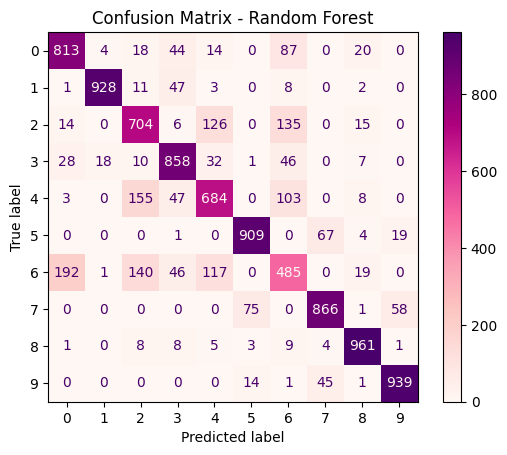

In [19]:
# c) Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [10, 15, 20, None], 'max_samples' : [0.7, 0.8, 0.9, 1.0]}
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid_rf,
    cv=5,
    n_iter=10,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1  # Paralelizăm pe toate nucleele disponibile
)

rf_search.fit(x_train_fashion_stand, y_train_fashion)

# Predictions and evaluation
y_pred_log_reg = rf_search.predict(x_test_fashion_stand)
print("Best Params:", rf_search.best_params_)
print("Random Forest Report:\n", classification_report(y_test_fashion, y_pred_log_reg))
ConfusionMatrixDisplay.from_predictions(y_test_fashion, y_pred_log_reg, cmap='RdPu')
plt.title('Confusion Matrix - Random Forest')
plt.show()  

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid

# Random Forest Model
rf = RandomForestClassifier(random_state=42)

# Parametri specificați pentru Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20, None],
    'max_samples': [0.7, 0.8, 0.9, 1.0]
}

# Generăm toate combinațiile posibile de parametri
param_combinations_rf = list(ParameterGrid(param_grid_rf))

# Parcurgem fiecare combinație de hiperparametri
for params in param_combinations_rf:
    # Configurăm modelul cu parametrii curenți
    rf.set_params(**params)
    
    # Antrenăm modelul (doar dacă trebuie refăcut complet, altfel presupunem că e pregătit)
    rf.fit(x_train_fashion_stand, y_train_fashion)
    
    # Facem predicții pe setul de test
    y_pred_fashion_rf = rf.predict(x_test_fashion_stand)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- Random Forest Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(y_test_fashion, y_pred_fashion_rf))



--- Random Forest Report for params: {'max_depth': 10, 'max_samples': 0.7, 'n_estimators': 50} ---
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1000
           1       0.96      0.90      0.93      1000
           2       0.62      0.68      0.65      1000
           3       0.75      0.83      0.79      1000
           4       0.64      0.63      0.64      1000
           5       0.88      0.89      0.89      1000
           6       0.49      0.37      0.42      1000
           7       0.87      0.85      0.86      1000
           8       0.92      0.95      0.94      1000
           9       0.91      0.92      0.91      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000


--- Random Forest Report for params: {'max_depth': 10, 'max_samples': 0.7, 'n_estimators': 100} ---
              precision    recall  f1-sc

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Renata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [12:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
Gradient Boosted Trees Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.97      0.94      0.96      1000
           2       0.72      0.71      0.72      1000
           3       0.83      0.85      0.84      1000
           4       0.72      0.72      0.72      1000
           5       0.93      0.93      0.93      1000
           6       0.57      0.54      0.55      1000
           7       0.90      0.90      0.90      1000
           8       0.95      0.96      0.96      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



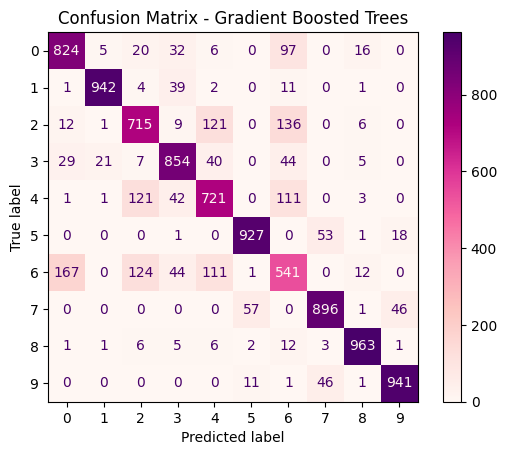

In [ ]:
# d) Gradient Boosted Trees (XGBoost)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

# Gradient Boosted Trees - XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid_xgb,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)
xgb_search.fit(x_train_fashion_stand, y_train_fashion)

# Predictions and evaluation
y_pred_log_reg = xgb_search.predict(x_test_fashion_stand)
print("Best Params:", xgb_search.best_params_)
print("Gradient Boosted Trees Report:\n", classification_report(y_test_fashion, y_pred_log_reg))
ConfusionMatrixDisplay.from_predictions(y_test_fashion, y_pred_log_reg, cmap='RdPu')
plt.title('Confusion Matrix - Gradient Boosted Trees')
plt.show()  


In [128]:
# XGBoost Model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Parametri specificați pentru XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Generăm toate combinațiile posibile de parametri
param_combinations_xgb = list(ParameterGrid(param_grid_xgb))

# Parcurgem fiecare combinație de hiperparametri
for params in param_combinations_xgb:
    # Configurăm modelul cu parametrii curenți
    xgb_model.set_params(**params)
    
    # Antrenăm modelul (doar dacă trebuie refăcut complet, altfel presupunem că e pregătit)
    xgb_model.fit(x_train_fashion_stand, y_train_fashion)
    
    # Facem predicții pe setul de test
    y_pred_fashion_xgb = xgb_model.predict(x_test_fashion_stand)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- Gradient Boosted Trees Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(y_test_fashion, y_pred_fashion_xgb))


--- Gradient Boosted Trees Report for params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50} ---
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1000
           1       0.93      0.85      0.89      1000
           2       0.47      0.59      0.52      1000
           3       0.66      0.77      0.71      1000
           4       0.46      0.43      0.45      1000
           5       0.79      0.82      0.80      1000
           6       0.39      0.30      0.34      1000
           7       0.82      0.77      0.79      1000
           8       0.84      0.80      0.82      1000
           9       0.87      0.89      0.88      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000


--- Gradient Boosted Trees Report for params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} ---
              prec

#### FRUITS

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'multi_class': 'multinomial', 'C': 1}
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       157
           1       0.69      0.77      0.73       164
           2       0.71      0.68      0.69       148
           3       0.98      0.91      0.94       160
           4       0.95      0.77      0.86       164
           5       0.66      0.76      0.71       161
           6       0.61      0.66      0.63       164
           7       0.97      0.99      0.98       234
           8       0.65      0.99      0.79       152
           9       0.44      0.40      0.42       164
          10       0.81      0.79      0.80       164
          11       0.55      0.46      0.50       144
          12       0.89      0.88      0.88       166
          13       0.50      0.50      0.50       164
          14       0.95      0.87      0.90    

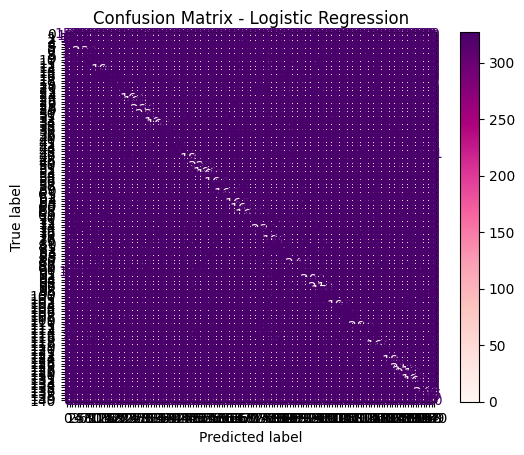

In [112]:
# FRUITS TODO: 16x16 1x1 hog
# Logistic Regression with Hyperparameter Tuning
log_reg = LogisticRegression(max_iter=1000)  # Sufficient iterations for convergence
param_grid_logreg = {
    'C': [0.01, 0.05, 0.1, 0.5, 1],
    'multi_class': ["ovr", "multinomial"]
}
log_reg_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_grid_logreg,
    cv=5,
    n_iter=10,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

log_reg_search.fit(x_train_fruits_stand, y_train_fruits)

# Predictions and evaluation
y_pred_log_reg = log_reg_search.predict(x_test_fruits_stand)
print("Best Params:", log_reg_search.best_params_)

print("Logistic Regression Report:\n", classification_report(y_test_fruits, y_pred_log_reg))
ConfusionMatrixDisplay.from_predictions(y_test_fruits, y_pred_log_reg, cmap='RdPu')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Logistic Regression Report for Top 10 Classes:
                       precision    recall  f1-score   support

        Grape Blue 1       1.00      1.00      1.00       328
              Plum 3       1.00      0.92      0.96       304
Melon Piel de Sapo 1       1.00      0.90      0.95       246
            Tomato 3       0.94      0.88      0.91       246
    Cherry Rainier 1       1.00      0.60      0.75       246
            Cherry 2       0.90      0.96      0.93       246
            Tomato 1       0.97      0.87      0.92       246
  Strawberry Wedge 1       0.97      0.75      0.85       246
             Peach 2       1.00      1.00      1.00       246
            Walnut 1       1.00      1.00      1.00       249

           micro avg       0.98      0.89      0.93      2603
           macro avg       0.98      0.89      0.93      2603
        weighted avg       0.98      0.89      0.93      2603



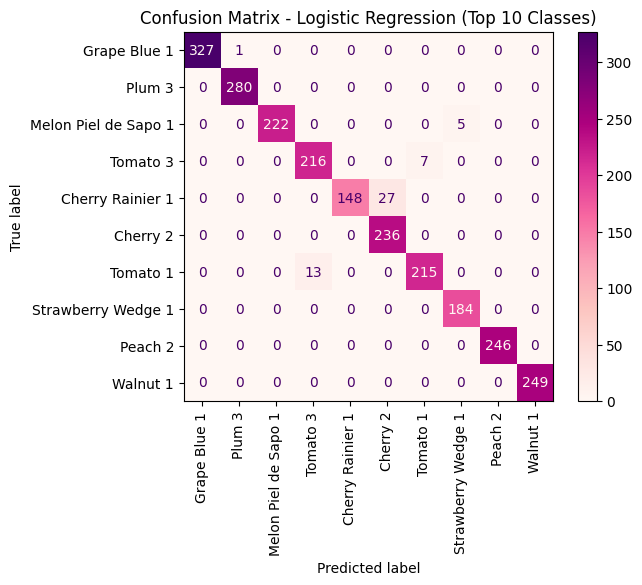

In [113]:
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Exemplu: lista fruits_class_names (de la 0 la N-1) cu numele claselor
# fruits_class_names = ["apple", "banana", "cherry", "date", ...]

# Obținem indicii pentru cele 10 clase cele mai populate din fruits_class_names
top_10_class_indices = [fruits_class_names.index(class_name) for class_name in top_10_class_names]

# Filtrăm setul de test și predicțiile pentru cele 10 clase
mask_top_10_classes = np.isin(y_test_fruits, top_10_class_indices)
y_test_top_10 = y_test_fruits[mask_top_10_classes]
y_pred_top_10 = y_pred_log_reg[mask_top_10_classes]

# Verificăm dacă există date pentru aceste clase
if len(np.unique(y_test_top_10)) == 0:
    raise ValueError("Nu există date pentru cele 10 clase în setul de test.")

# Mapăm indicii claselor la numele lor pentru raport și afișare
target_names_top_10 = [fruits_class_names[idx] for idx in top_10_class_indices]

# Generăm raportul de clasificare pentru cele 10 clase, specificând `labels`
print("Logistic Regression Report for Top 10 Classes:\n", classification_report(
    y_test_top_10, y_pred_top_10, labels=top_10_class_indices, target_names=target_names_top_10
))

# Generăm matricea de confuzie pentru cele 10 clase, specificând `labels`
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_top_10,
    y_pred_top_10,
    labels=top_10_class_indices,  # Explicităm clasele relevante
    display_labels=target_names_top_10,  # Folosim numele claselor pentru afișare
    cmap='RdPu'
)
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)
plt.title('Confusion Matrix - Logistic Regression (Top 10 Classes)')
plt.show()


In [ ]:

# Parametri specificați
param_grid_logreg = {
    'C': [0.01, 0.05, 0.1, 0.5, 1],
    'multi_class': ["ovr", "multinomial"]
}

# Generăm combinațiile de hiperparametri
param_combinations_logreg = list(ParameterGrid(param_grid_logreg))
x_test_top_10 = x_test_fruits_stand[mask_top_10_classes]

# Iterăm prin fiecare combinație de hiperparametri
for params in param_combinations_logreg:
    # Configurăm modelul cu parametrii curenți
    log_reg.set_params(**params)
    
    # Antrenăm modelul
    log_reg.fit(x_train_fruits_stand, y_train_fruits)
    
    # Facem predicții doar pentru setul filtrat (primele 10 clase)
    y_pred_top_10 = log_reg.predict(x_test_top_10)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- Logistic Regression Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(
        y_test_top_10, y_pred_top_10,
        labels=top_10_class_indices, target_names=target_names_top_10
    ))
    


--- Logistic Regression Report for params: {'C': 0.01, 'multi_class': 'ovr'} ---
                      precision    recall  f1-score   support

        Grape Blue 1       1.00      0.93      0.96       328
              Plum 3       0.90      0.77      0.83       304
Melon Piel de Sapo 1       0.99      0.68      0.81       246
            Tomato 3       0.96      0.61      0.74       246
    Cherry Rainier 1       0.99      0.41      0.58       246
            Cherry 2       0.86      0.85      0.86       246
            Tomato 1       0.89      0.95      0.92       246
  Strawberry Wedge 1       0.92      0.59      0.71       246
             Peach 2       1.00      1.00      1.00       246
            Walnut 1       1.00      1.00      1.00       249

           micro avg       0.95      0.78      0.86      2603
           macro avg       0.95      0.78      0.84      2603
        weighted avg       0.95      0.78      0.84      2603


--- Logistic Regression Report for params: {'C

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Renata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params: {'kernel': 'rbf', 'C': 10}
SVM Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       157
           1       0.73      0.76      0.75       164
           2       0.91      0.80      0.85       148
           3       0.91      0.74      0.82       160
           4       0.86      0.97      0.91       164
           5       0.66      0.85      0.74       161
           6       0.80      0.66      0.72       164
           7       0.89      1.00      0.94       234
           8       0.90      0.99      0.94       152
           9       0.73      0.66      0.69       164
          10       0.63      0.85      0.73       164
          11       0.66      0.83      0.74       144
          12       1.00      1.00      1.00       166
          13       0.84      0.96      0.89       164
          14       0.95      1.00      0.97       219
          15       0.99      0.88      0.93       164
          16       0.90     

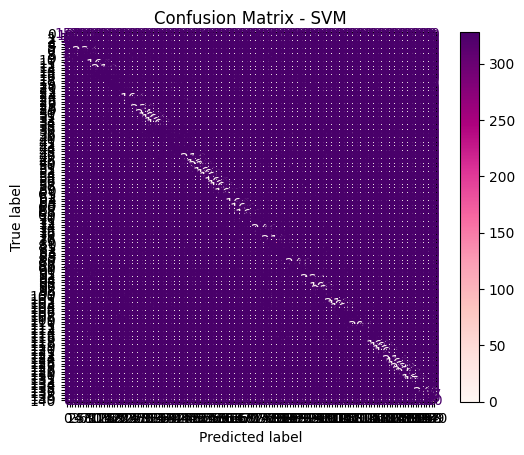

In [114]:
# 2. SVM - Fruits
svm = SVC(random_state=42)
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_search = RandomizedSearchCV(
    svm,
    param_distributions=param_grid_svm,
    cv=5,  # Reducem numărul de fold-uri
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1  # Paralelizăm pe toate nucleele disponibile
)
svm_search.fit(x_train_fruits_stand, y_train_fruits)

# Predictions and evaluation
y_pred_svm = svm_search.predict(x_test_fruits_stand)
print("Best Params:", svm_search.best_params_)
print("SVM Report:\n", classification_report(y_test_fruits, y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test_fruits, y_pred_svm, cmap='RdPu')
plt.title('Confusion Matrix - SVM')
plt.show()  

SVM Report for Top 10 Classes:
                       precision    recall  f1-score   support

        Grape Blue 1       1.00      1.00      1.00       328
              Plum 3       1.00      1.00      1.00       304
Melon Piel de Sapo 1       1.00      1.00      1.00       246
            Tomato 3       0.97      0.99      0.98       246
    Cherry Rainier 1       1.00      0.74      0.85       246
            Cherry 2       0.85      1.00      0.92       246
            Tomato 1       1.00      0.97      0.98       246
  Strawberry Wedge 1       1.00      0.87      0.93       246
             Peach 2       1.00      1.00      1.00       246
            Walnut 1       1.00      1.00      1.00       249

           micro avg       0.98      0.96      0.97      2603
           macro avg       0.98      0.96      0.97      2603
        weighted avg       0.98      0.96      0.97      2603



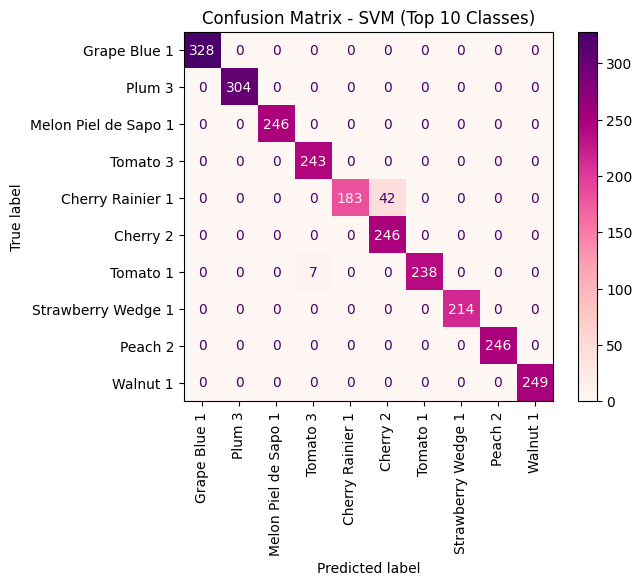

In [115]:
# Filtrăm setul de test și predicțiile pentru cele mai populate 10 clase
top_10_class_indices = [fruits_class_names.index(class_name) for class_name in top_10_class_names]
mask_top_10_classes = np.isin(y_test_fruits, top_10_class_indices)
y_test_top_10 = y_test_fruits[mask_top_10_classes]
y_pred_top_10 = y_pred_svm[mask_top_10_classes]

# Verificăm dacă există date pentru aceste clase
if len(np.unique(y_test_top_10)) == 0:
    raise ValueError("Nu există date pentru cele 10 clase în setul de test.")

# Mapăm indicii claselor la numele lor pentru raport și afișare
target_names_top_10 = [fruits_class_names[idx] for idx in top_10_class_indices]

# Generăm raportul de clasificare pentru cele 10 clase, specificând `labels`
print("SVM Report for Top 10 Classes:\n", classification_report(
    y_test_top_10, y_pred_top_10, labels=top_10_class_indices, target_names=target_names_top_10
))

# Generăm matricea de confuzie pentru cele 10 clase, specificând `labels`
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_top_10,
    y_pred_top_10,
    labels=top_10_class_indices,  # Explicităm clasele relevante
    display_labels=target_names_top_10,  # Folosim numele claselor pentru afișare
    cmap='RdPu'
)

# Rotim etichetele axei x la 90 de grade
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)
plt.title('Confusion Matrix - SVM (Top 10 Classes)')
plt.show()

In [132]:
# Mapăm indicii claselor la numele lor pentru raport și afișare
target_names_top_10 = [fruits_class_names[idx] for idx in top_10_class_indices]
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Generăm combinațiile de hiperparametri
param_combinations_svm = list(ParameterGrid(param_grid_svm))

# Iterăm prin fiecare combinație de hiperparametri
for params in param_combinations_svm:
    # Configurăm modelul cu parametrii curenți
    svm.set_params(**params)
    
    # Antrenăm modelul
    svm.fit(x_train_fruits_stand, y_train_fruits)
    
    # Facem predicții doar pentru setul filtrat (primele 10 clase)
    y_pred_top_10 = svm.predict(x_test_top_10)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- SVM Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(
        y_test_top_10, y_pred_top_10,
        labels=top_10_class_indices, target_names=target_names_top_10
    ))
    


--- SVM Report for params: {'C': 0.01, 'kernel': 'linear'} ---
                      precision    recall  f1-score   support

        Grape Blue 1       1.00      1.00      1.00       328
              Plum 3       1.00      0.99      0.99       304
Melon Piel de Sapo 1       1.00      0.95      0.97       246
            Tomato 3       0.85      0.85      0.85       246
    Cherry Rainier 1       1.00      0.61      0.75       246
            Cherry 2       0.84      1.00      0.91       246
            Tomato 1       1.00      0.83      0.91       246
  Strawberry Wedge 1       1.00      0.69      0.82       246
             Peach 2       1.00      1.00      1.00       246
            Walnut 1       1.00      1.00      1.00       249

           micro avg       0.96      0.90      0.93      2603
           macro avg       0.97      0.89      0.92      2603
        weighted avg       0.97      0.90      0.92      2603


--- SVM Report for params: {'C': 0.01, 'kernel': 'rbf'} ---
    

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 100, 'max_samples': 0.9, 'max_depth': None}
Random Forest Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       157
           1       0.62      0.66      0.64       164
           2       0.77      0.84      0.80       148
           3       0.96      0.94      0.95       160
           4       0.66      0.95      0.78       164
           5       0.63      0.99      0.77       161
           6       0.95      0.68      0.79       164
           7       0.91      1.00      0.95       234
           8       0.77      0.70      0.74       152
           9       0.73      0.70      0.71       164
          10       0.73      0.76      0.74       164
          11       0.79      0.86      0.82       144
          12       0.98      1.00      0.99       166
          13       0.94      0.77      0.85       164
          14       0.85      0.

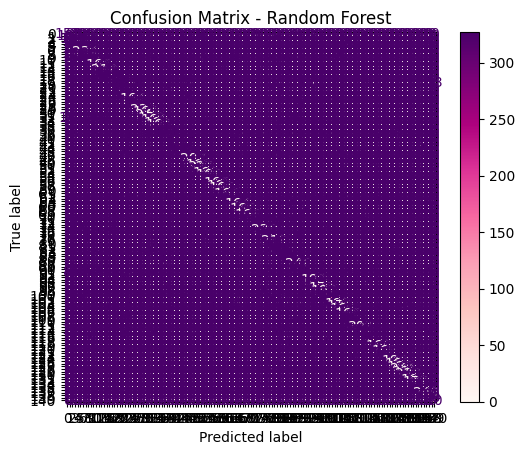

In [ ]:
# c) Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [10, 15, 20, None], 'max_samples' : [0.7, 0.8, 0.9, 1.0]}
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid_rf,
    cv=5,
    n_iter=10,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1  # Paralelizăm pe toate nucleele disponibile
)

rf_search.fit(x_train_fruits_stand, y_train_fruits)

# Predictions and evaluation
y_pred_rand_f = rf_search.predict(x_test_fruits_stand)
print("Best Params:", rf_search.best_params_)
print("Random Forest Report:\n", classification_report(y_test_fruits, y_pred_rand_f))
ConfusionMatrixDisplay.from_predictions(y_test_fruits, y_pred_rand_f, cmap='RdPu')
plt.title('Confusion Matrix - Random Forest')
plt.show() 

Random Forest Report for Top 10 Classes:
                       precision    recall  f1-score   support

        Grape Blue 1       1.00      1.00      1.00       328
              Plum 3       1.00      1.00      1.00       304
Melon Piel de Sapo 1       1.00      0.93      0.96       246
            Tomato 3       0.98      0.90      0.94       246
    Cherry Rainier 1       1.00      0.72      0.84       246
            Cherry 2       0.92      0.99      0.96       246
            Tomato 1       1.00      0.98      0.99       246
  Strawberry Wedge 1       0.93      0.77      0.84       246
             Peach 2       1.00      1.00      1.00       246
            Walnut 1       1.00      1.00      1.00       249

           micro avg       0.98      0.93      0.96      2603
           macro avg       0.98      0.93      0.95      2603
        weighted avg       0.98      0.93      0.96      2603



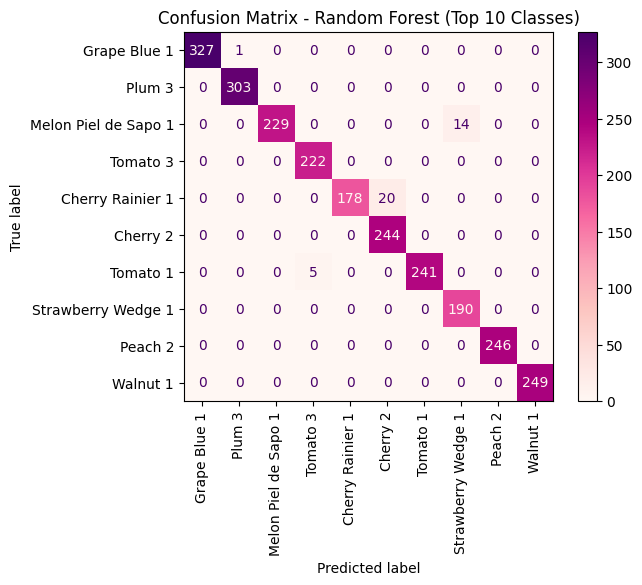

In [123]:
# Filtrăm setul de test și predicțiile pentru cele mai populate 10 clase
top_10_class_indices = [fruits_class_names.index(class_name) for class_name in top_10_class_names]
mask_top_10_classes = np.isin(y_test_fruits, top_10_class_indices)
y_test_top_10 = y_test_fruits[mask_top_10_classes]
y_pred_top_10 = y_pred_rand_f[mask_top_10_classes]

# Verificăm dacă există date pentru aceste clase
if len(np.unique(y_test_top_10)) == 0:
    raise ValueError("Nu există date pentru cele 10 clase în setul de test.")

# Mapăm indicii claselor la numele lor pentru raport și afișare
target_names_top_10 = [fruits_class_names[idx] for idx in top_10_class_indices]

# Generăm raportul de clasificare pentru cele 10 clase, specificând `labels`
print("Random Forest Report for Top 10 Classes:\n", classification_report(
    y_test_top_10, y_pred_top_10, labels=top_10_class_indices, target_names=target_names_top_10
))

# Generăm matricea de confuzie pentru cele 10 clase, specificând `labels`
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_top_10,
    y_pred_top_10,
    labels=top_10_class_indices,  # Explicităm clasele relevante
    display_labels=target_names_top_10,  # Folosim numele claselor pentru afișare
    cmap='RdPu'
)

# Rotim etichetele axei x la 90 de grade
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)
plt.title('Confusion Matrix - Random Forest (Top 10 Classes)')
plt.show()

In [ ]:
# Mapăm indicii claselor la numele lor pentru raport și afișare
target_names_top_10 = [fruits_class_names[idx] for idx in top_10_class_indices]

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [10, 15, 20, None], 'max_samples' : [0.7, 0.8, 0.9, 1.0]}

# Generăm combinațiile de hiperparametri
param_combinations_rf = list(ParameterGrid(param_grid_rf))

# Iterăm prin fiecare combinație de hiperparametri
for params in param_combinations_rf:
    # Configurăm modelul cu parametrii curenți
    rf.set_params(**params)
    
    # Antrenăm modelul
    rf.fit(x_train_fruits_stand, y_train_fruits)
    
    # Facem predicții doar pentru setul filtrat (primele 10 clase)
    y_pred_top_10 = rf.predict(x_test_top_10)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- Random Forest Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(
        y_test_top_10, y_pred_top_10,
        labels=top_10_class_indices, target_names=target_names_top_10
    ))
    


--- Random Forest Report for params: {'max_depth': 10, 'max_samples': 0.7, 'n_estimators': 50} ---
                      precision    recall  f1-score   support

        Grape Blue 1       1.00      0.93      0.97       328
              Plum 3       0.88      0.82      0.85       304
Melon Piel de Sapo 1       1.00      0.80      0.89       246
            Tomato 3       0.83      0.61      0.70       246
    Cherry Rainier 1       0.98      0.51      0.67       246
            Cherry 2       0.92      0.90      0.91       246
            Tomato 1       0.92      0.87      0.90       246
  Strawberry Wedge 1       0.79      0.54      0.65       246
             Peach 2       1.00      1.00      1.00       246
            Walnut 1       1.00      0.96      0.98       249

           micro avg       0.94      0.80      0.86      2603
           macro avg       0.93      0.80      0.85      2603
        weighted avg       0.93      0.80      0.85      2603


--- Random Forest Report for

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Gradient Boosted Trees Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       157
           1       0.64      0.70      0.67       164
           2       0.88      0.72      0.79       148
           3       0.98      0.78      0.86       160
           4       0.79      0.83      0.81       164
           5       0.72      1.00      0.83       161
           6       0.85      0.71      0.77       164
           7       0.97      1.00      0.98       234
           8       0.73      0.83      0.78       152
           9       0.62      0.65      0.63       164
          10       0.87      0.90      0.88       164
          11       0.88      0.83      0.85       144
          12       0.95      0.99      0.97       166
          13       0.58      0.81      0.67       164
          14       0.92

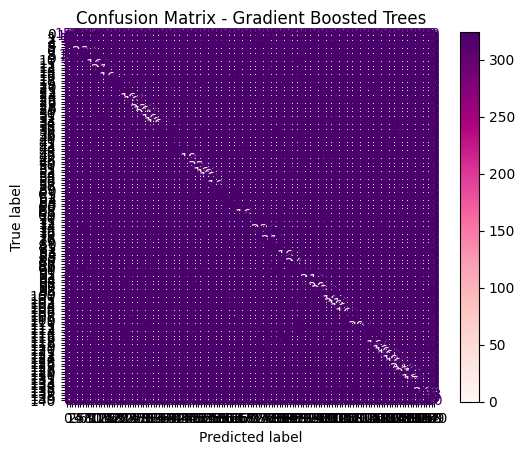

In [29]:
# d) Gradient Boosted Trees (XGBoost)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

# Gradient Boosted Trees - XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid_xgb,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)
xgb_search.fit(x_train_fruits_stand, y_train_fruits)

# Predictions and evaluation
y_pred_xgb = xgb_search.predict(x_test_fruits_stand)
print("Best Params:", xgb_search.best_params_)
print("Gradient Boosted Trees Report:\n", classification_report(y_test_fruits, y_pred_xgb))
ConfusionMatrixDisplay.from_predictions(y_test_fruits, y_pred_xgb, cmap='RdPu')
plt.title('Confusion Matrix - Gradient Boosted Trees')
plt.show()  


Gradient Boosted Trees Report for Top 10 Classes:
                       precision    recall  f1-score   support

        Grape Blue 1       1.00      0.99      0.99       328
              Plum 3       0.99      1.00      0.99       304
Melon Piel de Sapo 1       1.00      0.89      0.94       246
            Tomato 3       0.98      0.89      0.93       246
    Cherry Rainier 1       0.98      0.65      0.78       246
            Cherry 2       1.00      0.98      0.99       246
            Tomato 1       1.00      0.98      0.99       246
  Strawberry Wedge 1       0.90      0.76      0.83       246
             Peach 2       1.00      1.00      1.00       246
            Walnut 1       1.00      1.00      1.00       249

           micro avg       0.99      0.92      0.95      2603
           macro avg       0.98      0.91      0.94      2603
        weighted avg       0.98      0.92      0.95      2603



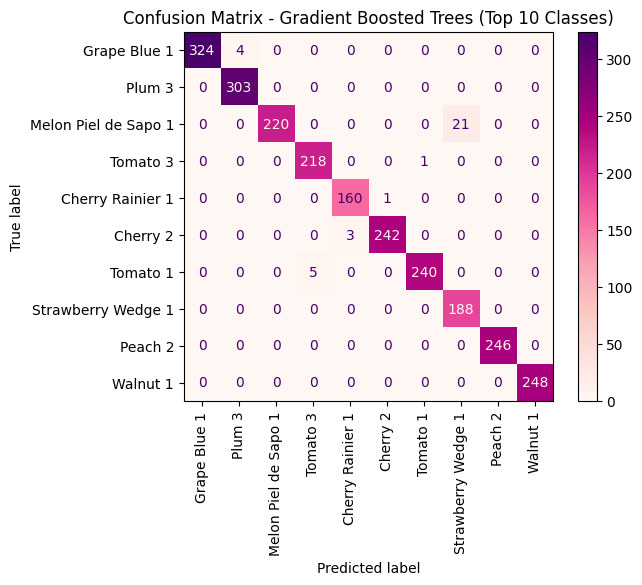

In [35]:
# Filtrăm setul de test și predicțiile pentru cele mai populate 10 clase
top_10_class_indices = [fruits_class_names.index(class_name) for class_name in top_10_class_names]
mask_top_10_classes = np.isin(y_test_fruits, top_10_class_indices)
y_test_top_10 = y_test_fruits[mask_top_10_classes]
y_pred_top_10 = y_pred_xgb[mask_top_10_classes]

# Verificăm dacă există date pentru aceste clase
if len(np.unique(y_test_top_10)) == 0:
    raise ValueError("Nu există date pentru cele 10 clase în setul de test.")

# Mapăm indicii claselor la numele lor pentru raport și afișare
target_names_top_10 = [fruits_class_names[idx] for idx in top_10_class_indices]

# Generăm raportul de clasificare pentru cele 10 clase, specificând `labels`
print("Gradient Boosted Trees Report for Top 10 Classes:\n", classification_report(
    y_test_top_10, y_pred_top_10, labels=top_10_class_indices, target_names=target_names_top_10
))

# Generăm matricea de confuzie pentru cele 10 clase, specificând `labels`
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_top_10,
    y_pred_top_10,
    labels=top_10_class_indices,  # Explicităm clasele relevante
    display_labels=target_names_top_10,  # Folosim numele claselor pentru afișare
    cmap='RdPu'
)

# Rotim etichetele axei x la 90 de grade
disp.ax_.set_xticklabels(disp.display_labels, rotation=90)
plt.title('Confusion Matrix - Gradient Boosted Trees (Top 10 Classes)')
plt.show()

In [41]:
from sklearn.model_selection import ParameterGrid

# Mapăm indicii claselor la numele lor pentru raport și afișare
target_names_top_10 = [fruits_class_names[idx] for idx in top_10_class_indices]
x_test_top_10 = x_test_fruits_stand[mask_top_10_classes]

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Generăm combinațiile de hiperparametri
param_combinations_xgb = list(ParameterGrid(param_grid_xgb))

# Iterăm prin fiecare combinație de hiperparametri
for params in param_combinations_xgb:
    # Configurăm modelul cu parametrii curenți
    xgb_model.set_params(**params)
    
    # Antrenăm modelul
    xgb_model.fit(x_train_fruits_stand, y_train_fruits)
    
    # Facem predicții doar pentru setul filtrat (primele 10 clase)
    y_pred_top_10 = xgb_model.predict(x_test_top_10)
    
    # Afișăm combinația curentă de hiperparametri
    print(f"\n--- Gradient Boosted Trees Report for params: {params} ---")
    
    # Generăm și afișăm raportul de clasificare
    print(classification_report(
        y_test_top_10, y_pred_top_10,
        labels=top_10_class_indices, target_names=target_names_top_10
    ))
    


--- Gradient Boosted Trees Report for params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50} ---
                      precision    recall  f1-score   support

        Grape Blue 1       1.00      0.84      0.92       328
              Plum 3       0.82      0.92      0.87       304
Melon Piel de Sapo 1       1.00      0.67      0.80       246
            Tomato 3       0.95      0.47      0.63       246
    Cherry Rainier 1       0.97      0.31      0.47       246
            Cherry 2       0.94      0.91      0.92       246
            Tomato 1       0.95      0.90      0.92       246
  Strawberry Wedge 1       0.46      0.19      0.27       246
             Peach 2       1.00      0.90      0.95       246
            Walnut 1       1.00      0.89      0.94       249

           micro avg       0.92      0.71      0.80      2603
           macro avg       0.91      0.70      0.77      2603
        weighted avg       0.91      0.71      0.78      2603


--- Gradient Boos